# Import Library

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import albumentations as A

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
!nvidia-smi -L

GPU 0: GeForce RTX 3080 (UUID: GPU-a38dd65b-bdf5-159e-8b35-dd0c4396bd53)


# Import Dataset

In [6]:
df = pd.read_csv('../Making_Datasets/dataframe_with_label.csv', dtype='str')

display(df.head())
print(len(df))

,Unnamed: 0,cid,iupacname,label
0,0,297.png,methane,"[1, 4, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,6324.png,ethane,"[1, 6, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,6334.png,propane,"[1, 7, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,7843.png,butane,"[1, 8, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,8003.png,pentane,"[1, 10, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


8200


In [5]:
df.drop_duplicates('cid', inplace=True, ignore_index=True)
print(len(df))

8128


In [6]:
sequences = np.array(df.label.to_list())

label_cols = [ 'label_'+str(i) for i in range(sequences.shape[1])]

new_df = pd.DataFrame(sequences, columns = label_cols)

df = pd.concat([df, new_df], axis=1).drop('label', axis=1)

## Preprocessing Dataset

In [7]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [8]:
import json

def init_tokenizer(load_json = True):
    if load_json:        
        with open('tokenizer/index2word.json', 'r') as f1:
            tokenizer.index2word = json.load(f1)
            tokenizer.index2word = {int(k):v for k,v in tokenizer.index2word.items()}
        with open('tokenizer/longest_sentences.json', 'r') as f2:
            tokenizer.longest_sentences = json.load(f2)

        with open('tokenizer/num_words.json', 'r') as f3:
            tokenizer.num_words = json.load(f3)

        with open('tokenizer/word2count.json', 'r') as f4:
            tokenizer.word2count = json.load(f4)

        with open('tokenizer/word2index.json', 'r') as f5:
            tokenizer.word2index = json.load(f5)
    else:
        tokenizer.fit_on_texts(lst_iupacname[:])

In [9]:
init_tokenizer(True)
tokenizer.longest_sentences

67

In [10]:
BATCH_SIZE = 16
units = 512
vocab_size = len(tokenizer.word2index)

IMG_SIZE = 300
IMG_SHAPE = (300, 300, 3)

max_length_train = tokenizer.longest_sentences
max_length_test = tokenizer.longest_sentences

encoding_size = 512 # Determines dimension of the encodings of images
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create Dataset

In [11]:
transforms = A.Compose([
      A.RGBShift(p=0.2),
      A.GaussNoise(var_limit=(100, 150), p= 0.5),
      A.ShiftScaleRotate(interpolation=4, border_mode=1, p=1.0),
      #A.Blur(blur_limit= 3, p= 0.5),
      # HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
      A.Flip(p= 0.5), A.Transpose(p= 0.5),
      A.ToGray(p= 0.5),
      #A.ChannelShuffle(p= 0.5),
      #A.RandomBrightness(limit=(-0.10, 0.0), p= 0.5)
], p=0.9)

In [12]:
from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
from efficientnet.tfkeras import preprocess_input

img_gen = ImageDataAugmentor(augment = transforms, rescale=1./255, validation_split=0.2)

img_dir = '../Web_Scraping/kme_image_dataset/batch_1'
generator = img_gen.flow_from_dataframe(
    df, img_dir, x_col='cid', y_col=label_cols,
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE, subset='training'
)

generator_val = img_gen.flow_from_dataframe(
    df, img_dir, x_col='cid', y_col=label_cols,
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE, subset='validation'
)

Found 6503 validated image filenames.
Found 1625 validated image filenames.


In [13]:
dataset = tf.data.Dataset.from_generator(
    lambda: generator,
    output_types = (tf.float32, tf.float32
    ),
    output_shapes = ([None, 300, 300, 3], [None, tokenizer.longest_sentences])
).cache().prefetch(AUTOTUNE)

dataset_val = tf.data.Dataset.from_generator(
    lambda: generator_val,
    output_types = (tf.float32, tf.float32),
    output_shapes = ([None, 300, 300, 3], [None, tokenizer.longest_sentences])
).cache().prefetch(AUTOTUNE)

In [14]:
num_steps_train = generator.samples // BATCH_SIZE
num_steps_test = generator_val.samples // BATCH_SIZE

# Create Dataset

## Plot Augmentation

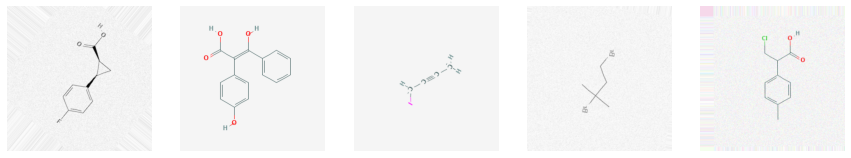

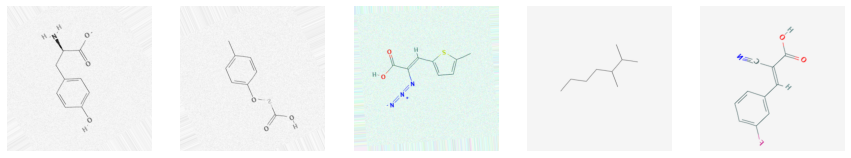

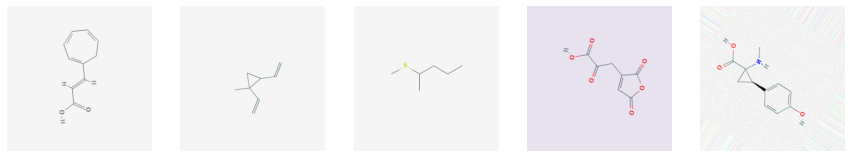

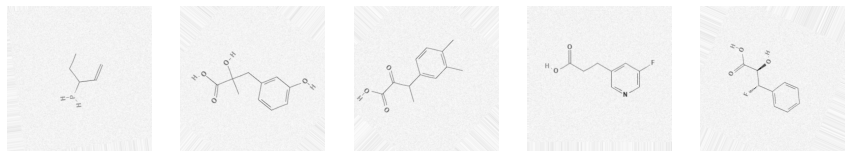

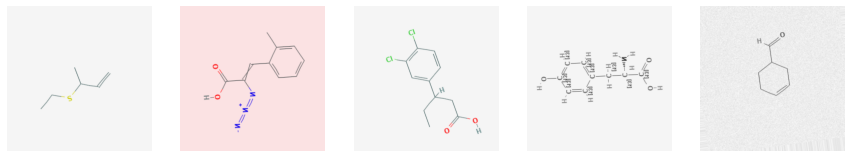

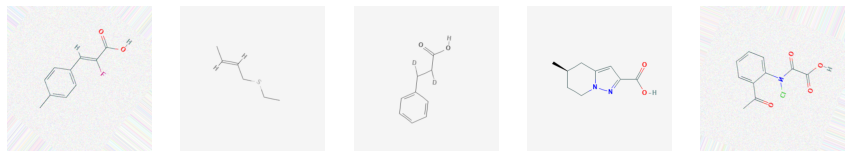

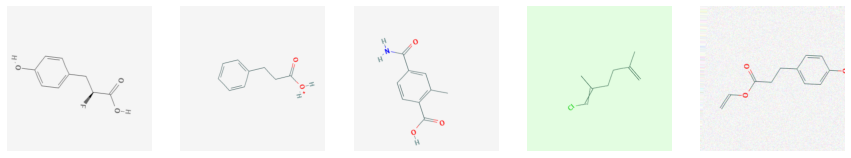

In [15]:
# Test parameter of ImageDataGenerator

for index, (img, label) in enumerate(dataset):
  plt.figure(figsize=(15, 15))
  for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow( img[i] )
    plt.axis('off')
  plt.show()
  if index == 6:
    break

# Model Architecture

## Efficientnet-B7

In [16]:
import efficientnet.tfkeras as efn

pret_model = efn.EfficientNetB3(include_top = False, weights='imagenet', input_shape=IMG_SHAPE)

pret_model.trainable = True

attention_features_shape = 10 * 10
features_shape = 1280

# Xception : [7, 7, 2048]
# InceptionResNetV2 : [5, 5, 1536]
# EfficientNetB0 : [7, 7, 2560]

Exception: URL fetch failure on https://github.com/Callidior/keras-applications/releases/download/efficientnet/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [20]:
pret_model.output.shape

TensorShape([None, 10, 10, 1280])

In [21]:
# tf.keras.utils.plot_model(pret_model, show_shapes = True, dpi = 46)

## CNN Encoder (Encoder output of feature extraction)

In [22]:
from tensorflow.keras.models import Sequential

def create_encoder():
  x = tf.keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer")(pret_model.output)
  output = tf.keras.layers.Reshape(target_shape=(attention_features_shape, encoding_size))(x)
  return tf.keras.Model(pret_model.input, output)

In [23]:
encoder = create_encoder()

In [24]:
# tf.keras.utils.plot_model(encoder, show_shapes = True, dpi = 46)

## Luong Attention

In [25]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM

In [26]:
def create_attention(features, hidden, method = 'concat'):
  # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)
  # hidden shape == (batch_size, hidden_size)
  
  # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
  hidden_with_time_axis = tf.expand_dims(hidden, 1)
  
  if method == 'concat':
    attention_hidden_layer = tf.nn.tanh( Dense(units)(features + hidden) )
  elif method == 'general':
    attention_hidden_layer = tf.matmul( features, Dense(units)(hidden), transpose_b=True )
  elif attention_hidden_layer == 'dot':
    attention_hidden_layer = tf.matmul( features, hidden, transpose_b=True )
  
  score = Dense(1)(attention_hidden_layer)
  attention_weights = tf.nn.softmax(score, axis=1)

  context_vector = attention_weights * features
  context_vector = tf.reduce_sum(context_vector, axis=1)
  
  return context_vector, attention_weights

## Create RNN Decoder

In [27]:
def create_decoder():
  features = tf.keras.layers.Input((attention_features_shape, encoding_size))
  dec_input= tf.keras.layers.Input((1))
  hidden = tf.keras.layers.Input((units))

  embedded = Embedding(vocab_size, encoding_size)(dec_input)

  lstm_output, state = GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')(embedded, initial_state=[hidden])
 
  context_vector, attention_weights = create_attention(features, lstm_output)

  # embedded shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
  output = tf.concat([context_vector, tf.squeeze(embedded, 1)], axis = -1)
  
  # shape == (batch_size, hidden_size)
  output = Dense(units, activation='tanh')(output)

  output = Dense(vocab_size, activation = 'softmax')(output)

  return tf.keras.models.Model([features, dec_input, hidden], [output, state, attention_weights])

def reset_state(batch_size):
  return tf.zeros((batch_size, units))

In [28]:
decoder = create_decoder()

tf.keras.utils.plot_model(decoder, show_shapes=True, dpi = 49);

# Custom Loss Function


In [29]:
def loss_fn(real, pred):
  # Word Loss

  real_onehot = tf.one_hot(tf.cast(real, tf.uint8), vocab_size)

  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction = 'none', label_smoothing=0.2)
  mask = tf.math.logical_not(tf.math.equal(real, tokenizer.word2index['<pad>'])) # make padding element -> true(1) -> false (0)
  loss_ = loss_object(real_onehot, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Metrics

## NLTK

In [30]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class Bleu(tf.keras.metrics.Metric):
  def __init__(self, name='bleu', **kwargs):
    super(Bleu, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='score', initializer='zeros')
    self.count = self.add_weight(name='count', initializer='zeros')
    self.chencherry = SmoothingFunction()

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = y_true[y_true != tokenizer.word2index['<pad>']]
    idx = np.where(y_pred == tokenizer.word2index['<end>'])[0]

    if idx != []:
      y_pred = y_pred[:idx[0]+1]
          
    values = sentence_bleu([y_true], y_pred, smoothing_function=self.chencherry.method4)

    self.count.assign_add(1)
    self.score.assign_add(values)

  def result(self):
    return self.score / self.count

  def reset_states(self):
    self.count.assign(0)
    self.score.assign(0)

# Callback

In [31]:
class EarlyStopping():
  def __init__(self, monitor = 'val_bleu', mode = 'max', patience = 1, encoder = encoder, decoder = decoder):
    if mode == 'max':
      self.mode = 'max'
      self.best = -100
    else: # Min
      self.min = 'min'
      self.best = 100
    self.patience = patience
    self.wait = 0
    self.encoder = encoder
    self.decoder = decoder

  def callback(self, log, epoch):
    if self.mode == 'max':
      if log < self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} < best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save('Luong_model/Encoder_model.h5', include_optimizer=False)
        self.decoder.save('Luong_model/Decoder_model.h5', include_optimizer=False)
        print('Save Model Succesful')
    else:
      if log > self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} > best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save('Luong_model/Encoder_model.h5', include_optimizer=False)
        self.decoder.save('Luong_model/Decoder_model.h5', include_optimizer=False)
        print('Save Model Succesful')
    
    return False
  

In [32]:
earlystop = EarlyStopping(patience = 7)

# Training Model

In [33]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001, decay_steps = 10000, decay_rate=0.96, staircase=True, name=None
)
opt = tf.keras.optimizers.Adam(0.0001)

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
bleu = Bleu()
bleu_val = Bleu()

## Train Step

In [34]:
@tf.function
def train_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_train_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0 
  
  with tf.GradientTape() as tape:
    img_feature = encoder(img_tensor, training = True)

    for i in range(1, target.shape[1]):
      # passing the features through the decoder
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = True)
      loss += loss_fn(target[:,i], predictions)
      
      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_train_pred = tf.concat( [dec_train_pred, predict_ids], axis = -1 )
      # using teacher forcing
      decoder_input = tf.expand_dims(target[:, i], 1)
      # Metrics
      mask = tf.math.logical_not(tf.math.equal(target[:, i], tokenizer.word2index['<pad>']))
      mask = tf.cast(mask, tf.float32)
      train_acc.update_state(target[:, i], predictions, sample_weight = mask)
  
  gradient = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables) 
  opt.apply_gradients(zip(gradient, encoder.trainable_variables + decoder.trainable_variables))

  return {'pred': dec_train_pred, 'loss': loss/target.shape[1], 'acc' : train_acc.result()}

## Test Step

In [35]:
@tf.function
def test_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_val_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor, training = False)

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = False)
      loss += loss_fn(target[:,i], predictions)

      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_val_pred = tf.concat( [dec_val_pred, predict_ids], axis = -1 )
        
      decoder_input = tf.expand_dims(target[:, i], 1)

      # Metrics
      mask = tf.math.logical_not(tf.math.equal(target[:, i], tokenizer.word2index['<pad>']))
      mask = tf.cast(mask, tf.float32)
      val_acc.update_state(target[:, i], predictions, sample_weight = mask)
  
  return {'pred': dec_val_pred, 'loss': loss/max_length_test, 'acc': val_acc.result()}

In [36]:
generator_test = ImageDataAugmentor(
  rescale = 1./255, validation_split=0.2).flow_from_dataframe(
    df, img_dir, x_col='cid', y_col='iupacname',
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = 120, subset='validation'
  )

dataset_test = tf.data.Dataset.from_generator(
  lambda: generator_test, 
  output_types = (tf.float32, tf.string),
  output_shapes = ([None, IMG_SIZE, IMG_SIZE, 3], [None, ])
).cache().prefetch(AUTOTUNE)

image_test, sequences_test = next(dataset_test.take(1).as_numpy_iterator())
caption_test = tokenizer.sequences_to_text(sequences_test)

Found 1625 validated image filenames.


In [37]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape)) # attention_features_shape

    hidden_state = reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    image = tf.cast(image, tf.float32)
    features = encoder( image, training = False )

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result = []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder([features, dec_input, hidden_state], training = False)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [38]:
def fit(epochs, num_steps, num_steps_val):
  for epoch in trange(1, epochs+1, leave=False):
    train_acc.reset_states()
    bleu.reset_states()
    total_loss, total_loss_val = 0, 0

    for index, (image, caption) in tqdm(enumerate(dataset.take(num_steps)), total=num_steps, leave=False):
      monitor = train_step(image, caption)
      total_loss += monitor['loss'].numpy()
  
      for i in range(tf.shape(caption)[0]):
        bleu.update_state(caption[i].numpy(), monitor['pred'][i].numpy())

    val_acc.reset_states()
    bleu_val.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset_val.take(num_steps_val)), total=num_steps_val, leave=False):
      monitor_val = test_step(image, caption)
      total_loss_val += monitor_val['loss']

      for i in range(tf.shape(caption)[0]):
        bleu_val.update_state(caption[i].numpy(), monitor_val['pred'][i].numpy())

    print(f'Epoch {epoch}/{epochs}\n'\
          f'loss : {(total_loss/num_steps):.4f} acc : {(monitor["acc"].numpy()):.4f} bleu : {(bleu.result().numpy()):.4f} '\
          f'val_loss : {(total_loss_val/num_steps_val):.4f} val_acc : {(monitor_val["acc"].numpy()):.4f} val_bleu : {(bleu_val.result().numpy()):.4f}'
    )
    result, _ = evaluate(image_test[12], tokenizer.longest_sentences)
    print("real:", caption_test[12], '\npredict:', result)

    if earlystop.callback(bleu_val.result().numpy(), epoch):
      break

    del monitor
    del monitor_val

## Fitting

In [39]:
fit(epochs = 50, num_steps = num_steps_train, num_steps_val = num_steps_test);

Epoch 1/50
loss : 1.1139 acc : 1.0373 bleu : 0.0993 val_loss : 0.9512 val_acc : 0.3792 val_bleu : 0.1318
real: ['buta', 'hexa', 'formyl', 'decan', 'oic acid', 'nitrosoprop', 'undec', 'acet', 'decan', 'hexa', 'en', 'hexa', '11', 'ic acid', 'N', 'formyl', 'decan', 'carboxylate', 'hexa', 'bis', '6', 'sulfan', 'hexa', 'oic acid', 'hepta', 'formyl', 'decan', 'oic acid', 'nitrosoprop', 'undec', 'hepta', 'oxan', 'oic acid', 'undec', 'carboxylate', 'ic acid', 'hexa', 'bis', 'hexa', 'oxo', 'one', 'nitrosoprop', 'benzyl', 'undec', 'acet', 'decan', 'carboxylate', 'hepta', 'oxo', 'dec', 'one', 'oxo', 'hepta', 'oic acid'] 
predict: ['1', '-', 'ene', '<end>']
Save Model Succesful
Epoch 2/50
loss : 0.8841 acc : 0.8774 bleu : 0.2565 val_loss : 0.6831 val_acc : 0.5515 val_bleu : 0.3188
real: ['buta', 'hexa', 'formyl', 'decan', 'oic acid', 'nitrosoprop', 'undec', 'acet', 'decan', 'hexa', 'en', 'hexa', '11', 'ic acid', 'N', 'formyl', 'decan', 'carboxylate', 'hexa', 'bis', '6', 'sulfan', 'hexa', 'oic acid

# Load Best Model

In [ ]:
# encoder.save('encoder_model.h5', include_optimizer=False)
# decoder.save('decoder_model.h5', include_optimizer=False)

encoder = tf.keras.models.load_model('Luong_model/Encoder_model.h5')
decoder = tf.keras.models.load_model('Luong_model/Decoder_model.h5')

# Caption It

In [2]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [3]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(''.join(result[:-1]), fontsize=22, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot((len_result//2)+1, (len_result//2)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='binary', alpha=0.5, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

# Dataset Test

In [4]:
# captions on the validation set
result, attention_plot = evaluate(image_test[5], max_length_test)

print ('Real Caption:', caption_test[5])
print ('Prediction Caption:', ''.join(result[:-1]))

plot_attention(image_test[5], result, attention_plot)

NameError: name 'evaluate' is not defined

# WER, MER, WIL, WIP

- WER = Word Error Rate
- MER = Match Error Rate
- WIL = Word Information Lost
- WIP = Word Information Preserved

In [2]:
import jiwer

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemoveWhiteSpace(replace_by_space=False),
    jiwer.SentencesToListOfWords(word_delimiter=" ")
]) 

In [3]:
ground_truth, _ = kme_segment.word_segmentation(caption_test[0])
hypothesis, _ = evaluate(image_test[0], max_length_test)
score = jiwer.compute_measures(
    ground_truth,
    hypothesis[:-1], 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

print(ground_truth)
print(hypothesis[:-1])
print(score)

NameError: name 'kme_segment' is not defined

# BLEU SCORE

In [74]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## All Bleu Score

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nami.AI.kme_tokenize import Segmentation

kme_segment = Segmentation()
score1, score2, score3, score4 = [], [], [], []
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)

  real_word,_ = kme_segment.word_segmentation(caption_test[i])
  try:
      score1 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(1.0, 0, 0, 0), smoothing_function = chencherry.method4)]))
      score2 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.5, 0.5, 0, 0), smoothing_function = chencherry.method4)]))
      score3 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.3, 0.3, 0.3, 0), smoothing_function = chencherry.method4)]))
      score4 = np.concatenate((score4, [sentence_bleu([real_word], word_arr[:-1], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function = chencherry.method4)]))
  except :
    None

In [76]:
print(f"BLEU1 {np.mean(score1)*100}\n"
      f"BLEU2 {np.mean(score2)*100}\n"
      f"BLEU3 {np.mean(score3)*100}\n"
      f"BLEU4 {np.mean(score4)*100}\n"
      )

BLEU1 11.106412649152462
BLEU2 11.098678841449926
BLEU3 11.094130839545574
BLEU4 11.583862693591236



In [77]:
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)
  real_word,_ = kme_segment.word_segmentation(caption_test[i])
  
  try:
      score = sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)
      best_score[i] = score
  except :
      None
  #print(f"{i} | {score:.4f}", end=' ')
  #print(''.join(word_arr[:-1]), end=' : ')
  #print(caption_test[i])

In [ ]:
sort_best_score = sorted(best_score.items(), key=lambda x: x[1], reverse=True)

In [ ]:
for i in range(30):
  print(sort_best_score[i][0], sort_best_score[i][1])

# Example

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[144], max_length_test)

print ('Real Caption:', caption_test[144])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[144])
plt.show()
plot_attention(image_test[144], result, attention_plot)


In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[38], max_length_test)

print ('Real Caption:', caption_test[38])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[38])
plt.show()
plot_attention(image_test[38], result, attention_plot)


In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_train[282], max_length_train)

print ('Real Caption:', caption_train[282])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_train[282])
plt.show()
plot_attention(image_train[282], result, attention_plot)


In [ ]:
plt.imshow(image_train[0,:,:,0], cmap='gray')

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[270], max_length_test)

print ('Real Caption:', caption_test[270])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[270])
plt.show()
plot_attention(image_test[270], result, attention_plot)
